In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# import acceleromter data
data = np.genfromtxt(r'data/20steps.txt',delimiter=',',skip_header=25)

In [3]:
sample_rate = 20/1000 # rate in seconds


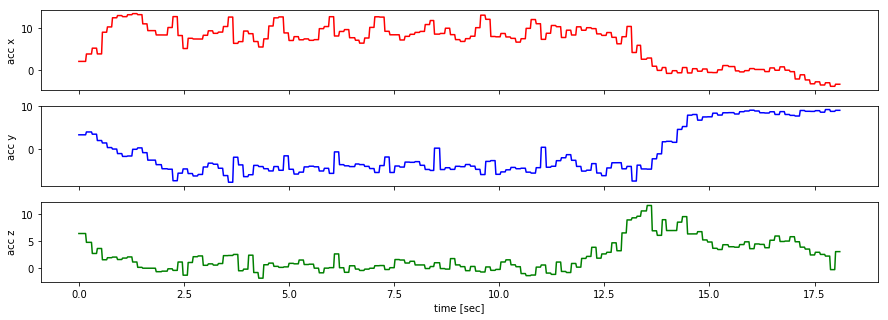

In [4]:
# plot accelerations data in each axes
fig, axs = plt.subplots(nrows=3, ncols=1,sharex=True, figsize=(15,5))

axs[0].plot(np.arange(len(data))*sample_rate,data[:,0],'-r')
axs[0].set_ylabel('acc x')

axs[1].plot(np.arange(len(data))*sample_rate,data[:,1],'-b')
axs[1].set_ylabel('acc y')

axs[2].plot(np.arange(len(data))*sample_rate,data[:,2],'-g')
axs[2].set_ylabel('acc z')

axs[2].set_xlabel('time [sec]')


plt.show()

In [5]:
# compute combined acceleromter magnitude
acc_magnitude = np.sqrt(data[:,0]**2 + data[:,1]**2 + data[:,2]**2)

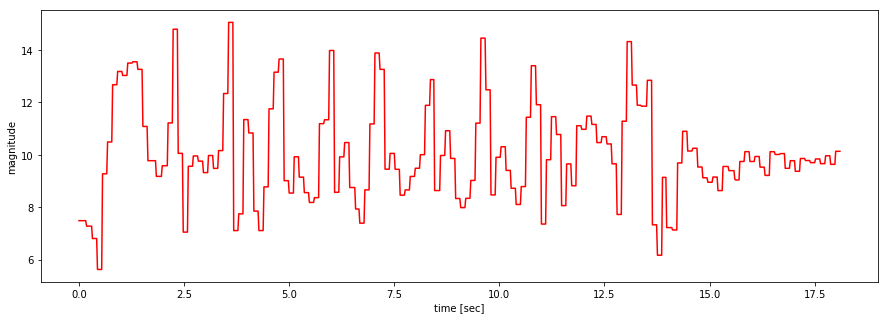

In [6]:
fig = plt.figure(figsize=(15,5))
plt.plot(np.arange(len(acc_magnitude))*sample_rate,acc_magnitude,'-r')
plt.ylabel('magnitude')
plt.xlabel('time [sec]')
plt.show()

# Peak Detection

In [7]:
def peak_detector(data, K):
    
    peaks =[]

    for i, datum in enumerate(data):
        if i > 0:
            if i-K < 0 :
            
                if datum >= max(data[:i]) and datum >=max(data[i+1:i+K+1]):
                    peaks.append(i)
                    time_from_last_peak = 0 

            elif i+K > len(data) :

                if datum >= max(data[i-K:i]) and datum >=max(data[i+1:]):
                    peaks.append(i)
                    time_from_last_peak = 0 
            else :

                if datum >= max(data[i-K:i]) and datum >=max(data[i+1:i+K+1]):
                        peaks.append(i)
                        time_from_last_peak = 0 



    return np.asarray(peaks)

In [8]:
# peak detection
K = int(0.4/sample_rate) # min distance between peaks threshold [samples]
peaks = peak_detector(acc_magnitude,K)

ValueError: max() arg is an empty sequence

In [ ]:
# plot result
fig = plt.figure(figsize=(15,5))
plt.plot(np.arange(len(acc_magnitude))*sample_rate,acc_magnitude,'-r')
plt.scatter(peaks*sample_rate,acc_magnitude[peaks])
plt.ylabel('acceleration magnitude')
plt.xlabel('time [sec]')
plt.title(str(len(peaks)) + ' peaks detected')
plt.show()

# Feature Analysis

Periodicity

In [ ]:
def calculate_periodicity_thresholds(peaks, sample_rate):
    # calculate min and max time difference between neighboring peaks 

    d = np.diff(peaks)* sample_rate
    T_max = np.average(d) + 3* np.std(d)
    T_min = np.average(d) - 3* np.std(d)
    
    return T_max, T_min

In [ ]:
T_max, T_min = calculate_periodicity_thresholds(peaks, sample_rate)

print('T max: ',T_max,' [sec]')
print('T min: ',T_min,' [sec]')

In [ ]:
def calculate_periodicity(i,peaks,sample_rate):
    # calculate min and max time difference between neighboring peaks 

    return (peaks[i] - peaks[i-1]) * sample_rate

Similarity

In [ ]:
def calculate_similarity_threshold(acc_magnitude,peaks):
    # calculate similarity threshold between neighboring peaks 

    peaks_magnitude = acc_magnitude[peaks]
    d_even = np.abs(np.diff(peaks_magnitude[::2]))
    d_odd = np.abs(np.diff(peaks_magnitude[1::2]))
    d = np.vstack([d_even,d_odd])
    sim_threshold = -1*(np.average(d) + 3*np.std(d))
    
    return sim_threshold

In [ ]:
sim_threshold = calculate_similarity_threshold(acc_magnitude,peaks)
print('similarity threshold: ' ,sim_threshold)

In [ ]:
def calculate_similarity(acc_magnitude,i,peaks):
    # calculate similarity  

    return -1*np.abs(acc_magnitude[peaks[i]]- acc_magnitude[peaks[i-2]])

Continuity

In [ ]:
# parameters for continuity computation
M = 2 # number threshold of continuity
N = 4 # window size of continuity
var_threshold = 500 # variance threshold for motion recognition

In [ ]:
def calculate_var_threshold(acc_magnitude,peaks,M,N):
    # determine continuity
    vars = []
    vars.append(np.var(acc_magnitude[0:peaks[0]]))
    for i in range(len(peaks)-1):
        vars.append(np.var(acc_magnitude[peaks[i]:peaks[i+1]]))
    vars = np.asarray(vars)
    return np.average(vars) - 3*np.std(vars)

In [ ]:
var_threshold = calculate_var_threshold(acc_magnitude,peaks,M,N)
print('var threshold: ', var_threshold )

In [ ]:
def calculate_continuity(i,acc_magnitude,peaks,M,N,var_threshold):
    # determine continuity 
    sum = 0
    for j in range(i-N+1,i+1):
        var = np.var(acc_magnitude[peaks[j]:peaks[j+1]]) 
        if var > var_threshold: # motion recognition
            sum += 1
    if sum >= M:
        C = 1
    else:
        C = 0
    return C

# Simulation

In [ ]:
K = 15
T_min = 0.3
T_max = 1
sim_threshold = -5
M = 2
N = 4
var_threshold = 0.7

In [ ]:
# import acceleromter data
sim_data = np.genfromtxt(r'data/Playing_phone_and_then_10_steps.csv',delimiter=',',skip_header=25)
sim_data = sim_data[:,1:]


In [ ]:
sample_rate = 10/1000 # rate in seconds
# compute combined acceleromter magnitude
acc_magnitude = np.sqrt(sim_data[:,0]**2 + sim_data[:,1]**2 + sim_data[:,2]**2)
fig = plt.figure(figsize=(15,5))
plt.plot(np.arange(len(acc_magnitude))*sample_rate,acc_magnitude,'-r')
plt.ylabel('magnitude')
plt.xlabel('time [sec]')
plt.show()

In [ ]:
# peak detection
K = int(0.4/sample_rate) # min distance between peaks threshold [samples]
peaks = peak_detector(acc_magnitude,K)
# plot result
fig = plt.figure(figsize=(15,5))
plt.plot(np.arange(len(acc_magnitude))*sample_rate,acc_magnitude,'-r')
plt.scatter(peaks*sample_rate,acc_magnitude[peaks])
plt.ylabel('acceleration magnitude')
plt.xlabel('time [sec]')
plt.title(str(len(peaks)) + ' peaks detected')
plt.show()

In [ ]:
# running simulation with the computed parameters
steps = []
steps_count = 0
for i in range(N-1,len(peaks)-1):
    C = calculate_continuity(i,acc_magnitude,peaks,M,N,var_threshold)
    # prints for debug
    print(C)
    print(calculate_similarity(acc_magnitude,i,peaks))
    print(calculate_periodicity(i,peaks,sample_rate))
    #
    if C == 0:
        continue
    elif calculate_similarity(acc_magnitude,i,peaks)<=sim_threshold:
        continue
    elif T_min<calculate_periodicity(i,peaks,sample_rate)<T_max:
        steps_count +=1
        steps.append(peaks[i])

steps = np.asarray(steps)
print('step count is: ',steps_count)



In [ ]:
# plot result
fig = plt.figure(figsize=(15,5))
plt.plot(np.arange(len(acc_magnitude))*sample_rate,acc_magnitude,'-r')
plt.scatter(steps*sample_rate,acc_magnitude[steps])
plt.ylabel('acceleration magnitude')
plt.xlabel('time [sec]')
plt.title(str(len(steps)) + ' steps detected')
plt.show()